

---


#  🟢 Série Temporal de Monóxido de Carbono para o Município de São Paulo (SP)

---
**DADOS**:
- `Acesso aos dados`: [Sentinel-5P NRTI CO: Near Real-Time Carbon Monoxide](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_CO)
- `Período dos dados`: 2018-11-22T12:00:13Z–2025-09-30T17:59:45Z
- `Resolução espacial`: 1113.2 metros
- `Resolução temporal`: diária


---
**REALIZAÇÃO**:


- Realizado por: Enrique V. Mattos - 30/09/2025
- E-mail: enrique@unifei.edu.br
- GitHub: https://github.com/evmpython
- Lattes: http://lattes.cnpq.br/8010078550088178



---

# **1° Passo:** Preparando ambiente

In [1]:
# instalando bibliotecas
!pip install -q ultraplot cartopy

# importa bibliotecas
import numpy as np
import ultraplot as uplt
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 77.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/ultraplot/__init__.py:77: UltraPlotWarning: Rebuilding font cache. This usually happens after installing or updating ultraplot.
  register_fonts(default=True)


# **2° Passo:** Mapas interativos

## 1) Preparando ambiente

In [2]:
# instalando eemont: biblioteca para extrair séries temporais no GEE
!pip install -q eemont

# importando GEE, geemap eemont
import ee, geemap, eemont

# inicializando GEE
geemap.ee_initialize(project='ee-enrique')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.6/184.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 kB 7.1 MB/s eta 0:00:00


## 2) Mapa no GEE

Imagem global para o dia 22/08/2024
- Temos 180 imagens em 1 dia de dados global

In [45]:
# data inicial e final
data_inicial = '2024-08-22'
data_final = '2024-08-23'

In [46]:
# carregando os dados de CO do satélite Sentinel 5P entre janeiro e agosto de 2025
S5P_co = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO') \
           .filterDate(data_inicial, data_final) \
           .select('CO_column_number_density')

In [47]:
# mostra a quantidade de imagens na tela
print('quantidade de imagens', S5P_co.size().getInfo())

quantidade de imagens 180


In [48]:
# mostra os dados que foram carregados
S5P_co

In [49]:
# mostra as datas
S5P_co2 = S5P_co.map(lambda img: img.set( {"DATE": ee.Date(img.get("system:time_start")).format("YYYY-MM-dd hh:mm")}))

dates_list = S5P_co2.aggregate_array("DATE").getInfo()
dates_df = pd.DataFrame(dates_list, columns=['DATE'])
dates_df

,DATE
0,2024-08-22 12:07
1,2024-08-22 12:12
2,2024-08-22 12:17
3,2024-08-22 12:22
4,2024-08-22 12:27
...,...
175,2024-08-22 10:47
176,2024-08-22 10:52
177,2024-08-22 11:47
178,2024-08-22 11:52


In [50]:
#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura do mapa
Map = geemap.Map()

# parâmetros de visualização
param_vis = {'min': 0, 'max': 150, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}


# plota mapa: O variável "CO_column_number_density" esta em unidades de "mol/m^2" para transformar para "Unidade Dobson (DU)" multiplica-se por 2241.15
Map.addLayer(S5P_co.mean().multiply(2241.15), param_vis, 'Mapa de CO')

# contornos
paises = ee.FeatureCollection('FAO/GAUL/2015/level0')
style1 = {'color': 'black', 'fillColor': '00000000'}
Map.addLayer(paises.style(**style1), {}, 'Paises')


# barra de cores
Map.add_colorbar_branca(colors=param_vis['palette'], vmin=param_vis['min'], vmax=param_vis['max'], layer_name='CO (DU)')

# exibe na tela
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Imagem para São Paulo

In [57]:
# contorno
regiao = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))
regiao

In [58]:
# carregando os dados de CO do satélite Sentinel 5P entre janeiro e agosto de 2025
S5P_co = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO') \
           .filterDate(data_inicial, data_final) \
           .filterBounds(regiao) \
           .select('CO_column_number_density')

In [59]:
# mostra a quantidade de imagens na tela
print('quantidade de imagens', S5P_co.size().getInfo())

quantidade de imagens 1


In [60]:
# mostra os dados que foram carregados
S5P_co

In [61]:
# mostra as datas
S5P_co2 = S5P_co.map(lambda img: img.set( {"DATE": ee.Date(img.get("system:time_start")).format("YYYY-MM-dd hh:mm")}))

dates_list = S5P_co2.aggregate_array("DATE").getInfo()
dates_df = pd.DataFrame(dates_list, columns=['DATE'])
dates_df

,DATE
0,2024-08-22 05:12


In [62]:
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
#brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#estado_mg = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Minas Gerais'))
#municipio_itajuba = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Itajuba'))
municipio_saopaulo = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura do mapa
Map = geemap.Map()

# centraliza o mapa na região
Map.centerObject(regiao,10)

# parâmetros de visualização
param_vis = {'min': 0, 'max': 150, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

# plota mapa: O variável "CO_column_number_density" esta em unidades de "mol/m^2" para transformar para "Unidade Dobson (DU)" multiplica-se por 2241.15
Map.addLayer(S5P_co.mean().clip(regiao).multiply(2241.15), param_vis, 'Mapa de CO')

# contorno da região
style1 = {'color': 'red', 'fillColor': '00000000'}
Map.addLayer(regiao.style(**style1), {}, 'MG')

# barra de cores
Map.add_colorbar_branca(colors=param_vis['palette'], vmin=param_vis['min'], vmax=param_vis['max'], layer_name='CO (DU)')

# exibe na tela
Map

Map(center=[-23.649520403301594, -46.64726567263275], controls=(WidgetControl(options=['position', 'transparen…

## 3) Produz série temporal

In [63]:
%%time
#========================================================================================================================#
#                                            FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
#regiao = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#regiao = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Minas Gerais'))
regiao = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

#========================================================================================================================#
#                                            DEFINE A DATA INICIAL E FINAL
#========================================================================================================================#
# período
data_inicial = '2019-01-01'
data_final = '2025-12-31'
print('PROCESSANDO')
print('#==========================================================================#')
print('DATA INICIAL:', data_inicial)
print('DATA FINAL:', data_final)
print('#==========================================================================#')

#========================================================================================================================#
#                                                  CARREGA OS DADOS
#========================================================================================================================#
# carrega os dados
S5P_co = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO') \
           .filterDate(data_inicial, data_final) \
           .filterBounds(regiao) \
           .select(['CO_column_number_density'], ['co'])

#========================================================================================================================#
#                                              PRODUZ SÉRIE TEMPORAL
#========================================================================================================================#
# gera a serie temporal
S5P_co_ts = S5P_co.getTimeSeriesByRegion(geometry = regiao,
                                         bands = 'co',
                                         reducer = ee.Reducer.max(),
                                         scale = 1000) # scale de 1000 metros

# inserindo os dados numa tabela
S5P_co_ts = geemap.ee_to_df(S5P_co_ts)

# transformando -9999.0 em NaN
S5P_co_ts[S5P_co_ts == -9999] = np.nan

# eliminando os dados NaN
S5P_co_ts = S5P_co_ts.dropna()

# transforma de mol/m^2	para DU
S5P_co_ts['co'] = S5P_co_ts['co']*2241.15

# transformando para DateTime
S5P_co_ts['date'] = pd.to_datetime(S5P_co_ts['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
S5P_co_ts.index = S5P_co_ts['date']

# remove coluna
S5P_co_ts.drop(['reducer', 'date'], inplace=True, axis=1)

#========================================================================================================================#
#                                                 AGRUPA POR DIA
#========================================================================================================================#
# agrupa os dados por dia
S5P_co_diario = S5P_co_ts.groupby(pd.Grouper(freq='1D')).max()

#========================================================================================================================#
#                                                 SALVA ARQUIVOS
#========================================================================================================================#
#S5P_co_ts.to_csv(f'{dir}/output/02_MONOXIDO_CARBONO/tabela_S5P_co_total.csv')
#S5P_co_diario.to_csv(f'{dir}/output/02_MONOXIDO_CARBONO/tabela_S5P_co_diaria.csv')

PROCESSANDO
#==========================================================================#
DATA INICIAL: 2019-01-01
DATA FINAL: 2025-12-31
#==========================================================================#
CPU times: user 70.1 ms, sys: 8.14 ms, total: 78.3 ms
Wall time: 59.2 s


In [64]:
S5P_co_ts

,co
date,
2019-01-01 15:58:44,56.101462
2019-01-01 17:38:45,63.082060
2019-01-02 17:18:44,69.356610
2019-01-03 16:58:45,74.518113
2019-01-04 16:43:45,76.083989
...,...
2025-09-27 16:54:46,74.767446
2025-09-28 16:39:45,69.199478
2025-09-29 16:19:45,80.398026


In [65]:
S5P_co_diario

,co
date,
2019-01-01,63.082060
2019-01-02,69.356610
2019-01-03,74.518113
2019-01-04,76.083989
2019-01-05,NaN
...,...
2025-09-26,54.255693
2025-09-27,74.767446
2025-09-28,69.199478


# **3° Passo:** Plota figura para 2025

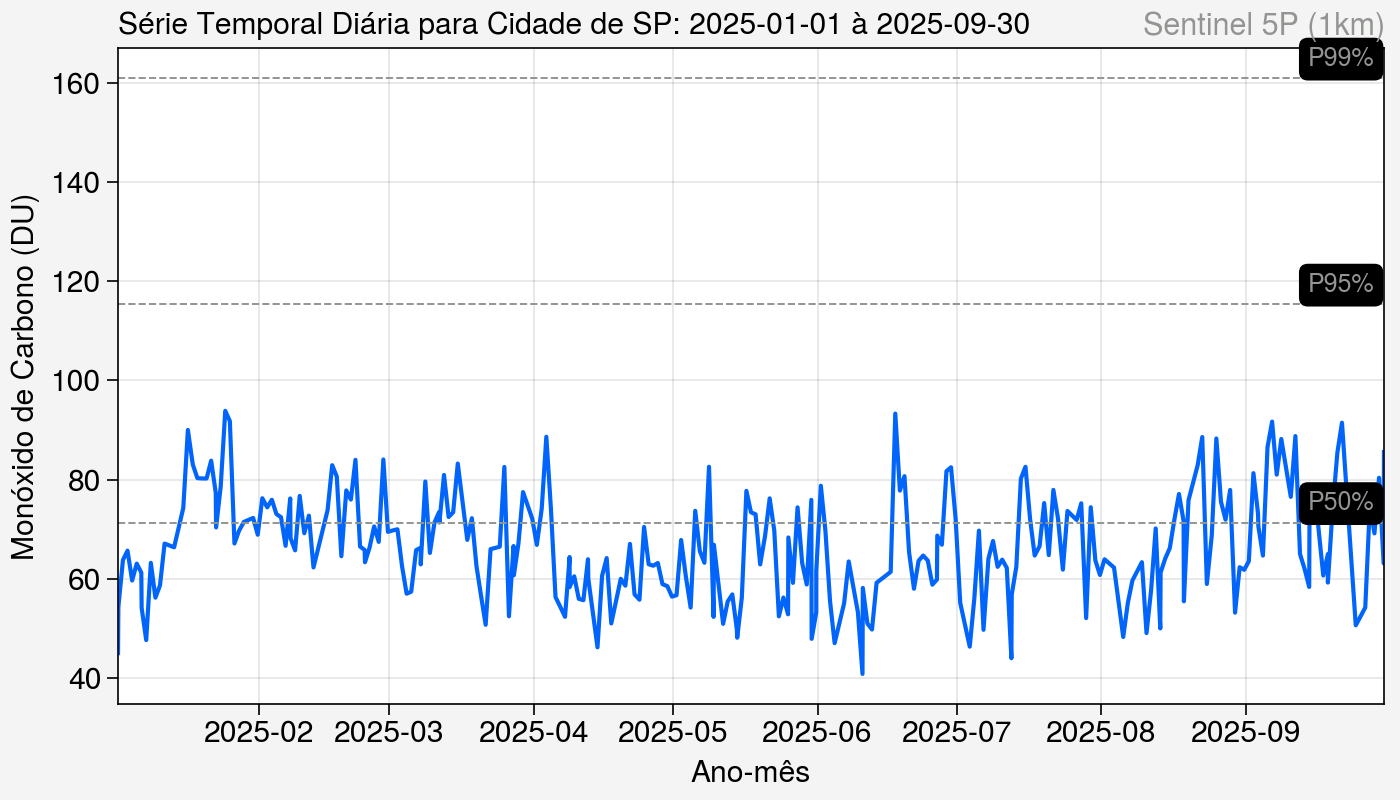

In [66]:
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(7,4), tight=True)

# plota gráfico de linha
di = '2025-01-01'
df = str(S5P_co_diario.index[-1])[0:10]

ax.plot(S5P_co_ts[di:df]['co'], color='bright blue')

# formato dos eixos
ax.format(ltitle=f'Série Temporal Diária para Cidade de SP: {di} à {df}',
          xlabel='Ano-mês',
          ylabel='Monóxido de Carbono (DU)',
          small='15px',
          large='15px',
          abc=False,
          xrotation=0,
          ytickminor=False,
          xtickminor=False)

# plota percentil de 50%, 95% e 99%
p50 = np.percentile(S5P_co_ts['co'].values, 50)
p95 = np.percentile(S5P_co_ts['co'].values, 95)
p99 = np.percentile(S5P_co_ts['co'].values, 99)

# plota percentil de 50%, 95% e 99%
ax.axhline(p50, color='gray', lw=0.7, linestyle='--')
ax.axhline(p95, color='gray', lw=0.7, linestyle='--')
ax.axhline(p99, color='gray', lw=0.7, linestyle='--')

# Calcular offset automático baseado no range dos dados
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]

offset = y_range * 0.01  # 2% do range vertical

ax.text(ax.get_xlim()[1] * 0.9999, p50 + offset, f'P50%',
        color='grey', fontsize=9, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='black', edgecolor='black', linewidth=1))

ax.text(ax.get_xlim()[1] * 0.9999, p95 + offset, f'P95%',
        color='grey', fontsize=9, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='black', edgecolor='black', linewidth=1))

ax.text(ax.get_xlim()[1] * 0.9999, p99 + offset, f'P99%',
        color='grey', fontsize=9, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='black', edgecolor='black', linewidth=1))

# nome do satélite
ax.text(0.81, 1.02, 'Sentinel 5P (1km)', color='grey', fontsize=11, transform=ax.transAxes)

# salva figura
fig.save('serie_temporal_co_diario_SP_1km_2025.jpg', dpi=300)

# exibe figura na tela
uplt.show()

# **4° Passo:** Plota figura entre 2019 e 2025

In [71]:
S5P_co_ts

,co
date,
2019-01-01 15:58:44,56.101462
2019-01-01 17:38:45,63.082060
2019-01-02 17:18:44,69.356610
2019-01-03 16:58:45,74.518113
2019-01-04 16:43:45,76.083989
...,...
2025-09-27 16:54:46,74.767446
2025-09-28 16:39:45,69.199478
2025-09-29 16:19:45,80.398026


In [70]:
S5P_co_diario

,co
date,
2019-01-01,63.082060
2019-01-02,69.356610
2019-01-03,74.518113
2019-01-04,76.083989
2019-01-05,NaN
...,...
2025-09-26,54.255693
2025-09-27,74.767446
2025-09-28,69.199478


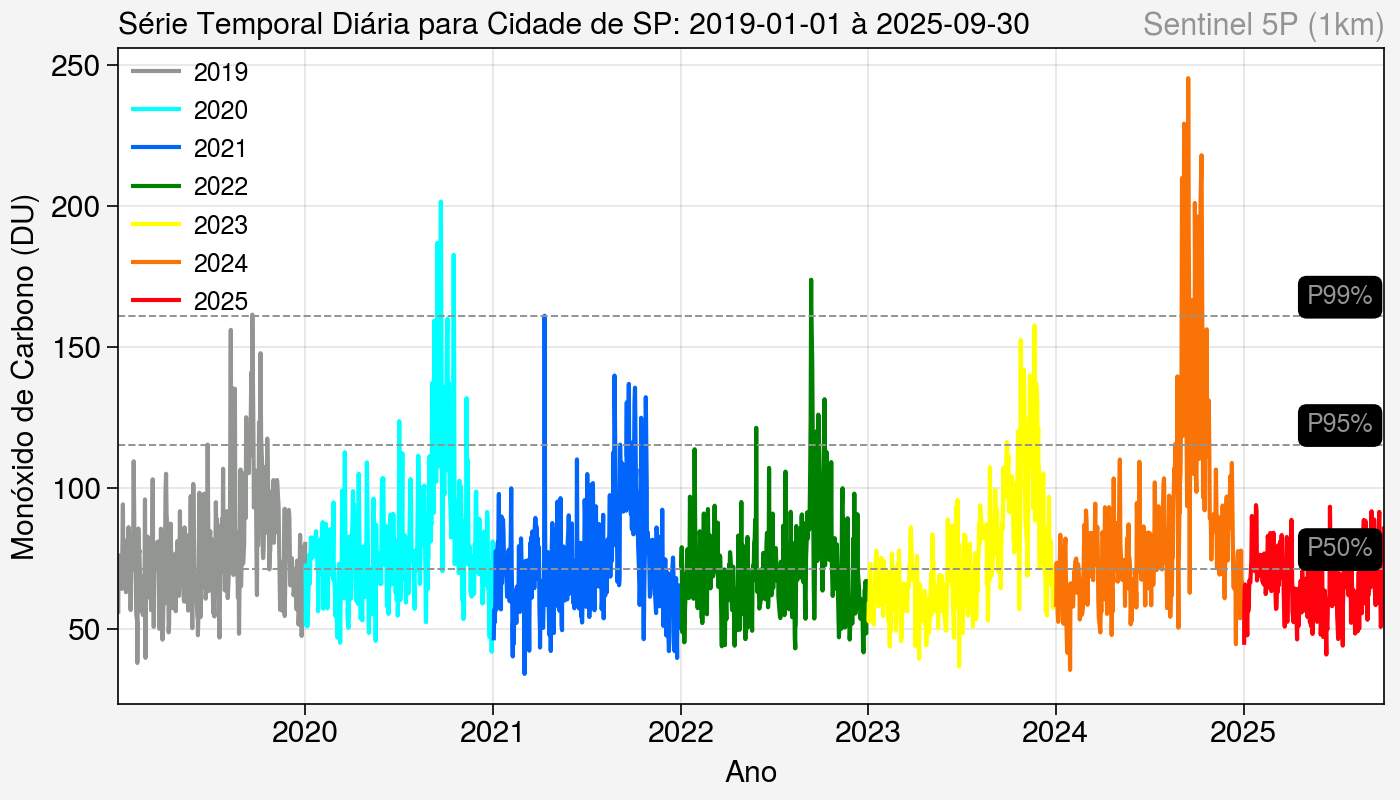

In [72]:
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(7,4), tight=True)

# data inicial e final da série temporal
di = str(S5P_co_diario.index[0])[0:10]
df = str(S5P_co_diario.index[-1])[0:10]

# plota gráfico de linha
ax.plot(S5P_co_ts[di: '2019-12-31']['co'], color='grey', label='2019')
ax.plot(S5P_co_ts['2020-01-01': '2020-12-31']['co'], color='cyan', label='2020')
ax.plot(S5P_co_ts['2021-01-01': '2021-12-31']['co'], color='bright blue', label='2021')
ax.plot(S5P_co_ts['2022-01-01': '2022-12-31']['co'], color='green', label='2022')
ax.plot(S5P_co_ts['2023-01-01': '2023-12-31']['co'], color='yellow', label='2023')
ax.plot(S5P_co_ts['2024-01-01': '2024-12-31']['co'], color='orange', label='2024')
ax.plot(S5P_co_ts['2025-01-01': df]['co'], color='bright red', label='2025')

# formatação dos eixos
ax.format(ltitle=f'Série Temporal Diária para Cidade de SP: {di} à {df}',
          xlabel='Ano',
          ylabel='Monóxido de Carbono (DU)',
          small='15px',
          large='15px',
          abc=False,
          xrotation=0,
          ytickminor=False,
          xtickminor=False)

# plota percentil de 50%, 95% e 99%
p50 = np.percentile(S5P_co_ts['co'].values, 50)
p95 = np.percentile(S5P_co_ts['co'].values, 95)
p99 = np.percentile(S5P_co_ts['co'].values, 99)

# plota percentil de 50%, 95% e 99%
ax.axhline(p50, color='gray', lw=0.7, linestyle='--')
ax.axhline(p95, color='gray', lw=0.7, linestyle='--')
ax.axhline(p99, color='gray', lw=0.7, linestyle='--')

# Calcular offset automático baseado no range dos dados
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]

offset = y_range * 0.01  # 2% do range vertical

ax.text(ax.get_xlim()[1] * 0.999, p50 + offset, f'P50%',
        color='grey', fontsize=9, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='black', edgecolor='black', linewidth=1))

ax.text(ax.get_xlim()[1] * 0.999, p95 + offset, f'P95%',
        color='grey', fontsize=9, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='black', edgecolor='black', linewidth=1))

ax.text(ax.get_xlim()[1] * 0.999, p99 + offset, f'P99%',
        color='grey', fontsize=9, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='black', edgecolor='black', linewidth=1))

# legenda
ax.legend(loc='ul', ncols=1, frameon=False)

# nome do satélite
ax.text(0.81, 1.02, 'Sentinel 5P (1km)', color='grey', fontsize=11, transform=ax.transAxes)

# salva figura
fig.save('serie_temporal_co_diario_SP_1km_2019_2025.jpg', dpi=300)

# exibe figura na tela
uplt.show()